## Baltimore-Crime-Arrest-Visualizations

This project aims to study the crime statistics and the number of arrests in relation with the crimes ( in the city of Baltimore) through Data Visualization using Python Library

In [25]:
# Name : Bharathvaj Devarajan 
# Data Source: https://data.baltimorecity.gov/

# Import the standard Libraries 
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
import matplotlib.pyplot as plt
from pylab import rcParams
from mpl_toolkits.basemap import Basemap
from matplotlib import cm

With SODA API's the limit for the number of records is set to 50000 which may be counter prodcutive in our case as we are
trying to establish a relationship between the crimes and the arrests
The query returns a "bad request error" if we try to increase the limit above 50000

In [26]:
api_link = ("https://data.baltimorecity.gov/resource/rp9g-42r9.json?$limit=50000")

In [27]:
raw_data = pd.read_json(api_link) # Crime Data from JSON  

In [28]:
print(len(raw_data))
del raw_data

50000


To overcome this limitation I acquired a CSV file of the same data 
There was a trade off between Real time data and static data , but since we were dealing with data records in excess of 
280000, it made sense to chose static data with all the records

<b>Loading the Data Sets from CSV files</b>

In [51]:
# Crime Data
crime_data = pd.read_csv("crimes.csv")
# Arrests Data
arrests_data = pd.read_csv("arrests.csv")

<b>Study the Datasets</b>

In [52]:
crime_data.head(5)

,CrimeDate,CrimeCode,Location,Description,Weapon,Post,District,Neighborhood,Location 1
0,11/12/2016 12:00:00 AM,3B,300 SAINT PAUL PL,ROBBERY - STREET,NaN,111.0,CENTRAL,Downtown,"(39.2924100000, -76.6140800000)"
1,11/12/2016 12:00:00 AM,3CF,800 S BROADWAY,ROBBERY - COMMERCIAL,FIREARM,213.0,SOUTHEASTERN,Fells Point,"(39.2824200000, -76.5928800000)"
2,11/12/2016 12:00:00 AM,6D,1500 PENTWOOD RD,LARCENY FROM AUTO,NaN,413.0,NORTHEASTERN,Stonewood-Pentwood-Winston,"(39.3480500000, -76.5883400000)"
3,11/12/2016 12:00:00 AM,6D,6600 MILTON LN,LARCENY FROM AUTO,NaN,424.0,NORTHEASTERN,Westfield,"(39.3626300000, -76.5516100000)"
4,11/12/2016 12:00:00 AM,6E,300 W BALTIMORE ST,LARCENY,NaN,111.0,CENTRAL,Downtown,"(39.2893800000, -76.6197100000)"


In [53]:
crime_data.shape

(285807, 9)

In [54]:
crime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285807 entries, 0 to 285806
Data columns (total 9 columns):
CrimeDate       285807 non-null object
CrimeCode       285807 non-null object
Location        284184 non-null object
Description     285807 non-null object
Weapon          97396 non-null object
Post            285616 non-null float64
District        285749 non-null object
Neighborhood    284106 non-null object
Location 1      284188 non-null object
dtypes: float64(1), object(8)
memory usage: 19.6+ MB


As we can see most of the Fields are in object format, so we have to change the types

<b>Cleaning the crime Dataset</b>

In [55]:
# Converting the object type to datetime format
crime_data['CrimeDate'] = pd.to_datetime(crime_data['CrimeDate'])
# Sorting the Data by CrimeDate
crime_data.sort_values(by='CrimeDate', inplace=True)
# Extracting the Timestamp fields and adding them onto the crime Dataset
crime_data['DayNumber']   = crime_data['CrimeDate'].dt.dayofweek
crime_data['DayName']     = crime_data['CrimeDate'].dt.weekday_name
crime_data['Day']         = crime_data['CrimeDate'].dt.day
crime_data['Year']        = crime_data['CrimeDate'].dt.year
crime_data['Month']       = crime_data['CrimeDate'].dt.month

# Cleanse the Location to extract the Coordniates

# Fill the coordinates value which are not null
coordinates = crime_data['Location 1'][crime_data['Location 1'].notnull()] 
# Initialize lists
locs_lon=[]
locs_lat=[]

# For loop to append latitudes and longitudes to these lists
for loc in coordinates:
    lat, lon = loc[1:-1].split(', ')
    locs_lon.append(float(lon))
    locs_lat.append(float(lat))


In [56]:
# Analyzing the Arrest Data
arrests_data.head(5)

,Arrest,Age,Sex,Race,ArrestDate,ArrestTime,ArrestLocation,IncidentOffense,IncidentLocation,Charge,ChargeDescription,District,Post,Neighborhood,Location 1
0,16160529.0,54.0,M,B,11/12/2016,22:35,3500 PELHAM AVE,4ECOMMON ASSAULT,3500 PELHAM AVE,1 1415,COMMON ASSAULT,Northeastern,432.0,Belair-Edison,"(39.3208685519, -76.5652449141)"
1,16160490.0,22.0,M,B,11/12/2016,21:49,300 S LOUDON AVE,Unknown Offense,300 S LOUDON AVE,4 3550,POSSESSION,Southwestern,833.0,Irvington,"(39.2811486601, -76.6821278085)"
2,16160487.0,31.0,M,B,11/12/2016,21:40,NaN,Unknown Offense,NaN,1 0077,FAILURE TO APPEAR,NaN,NaN,NaN,NaN
3,16160485.0,31.0,M,B,11/12/2016,20:30,NaN,Unknown Offense,NaN,1 0077,FAILURE TO APPEAR,NaN,NaN,NaN,NaN
4,16160481.0,33.0,M,B,11/12/2016,19:45,NaN,Unknown Offense,NaN,2 0480,MOTOR VEH/UNLAWFUL TAKING,NaN,NaN,NaN,NaN


In [57]:
arrests_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 130713 entries, 0 to 130712
Data columns (total 15 columns):
Arrest               123699 non-null float64
Age                  130685 non-null float64
Sex                  130713 non-null object
Race                 130713 non-null object
ArrestDate           130713 non-null object
ArrestTime           130713 non-null object
ArrestLocation       78595 non-null object
IncidentOffense      130713 non-null object
IncidentLocation     76987 non-null object
Charge               114255 non-null object
ChargeDescription    130211 non-null object
District             78601 non-null object
Post                 78583 non-null float64
Neighborhood         78595 non-null object
Location 1           78666 non-null object
dtypes: float64(3), object(12)
memory usage: 15.0+ MB


The arrests Data has 130000 entries as it has data from 2013 onwards only

In [58]:
# Like the CrimeData we have to segregate the Arrest Date into Days,Month and Year
arrests_data['ArrestDate']      = pd.to_datetime(arrests_data['ArrestDate'])
# Extracting the Timestamp Details
arrests_data['DayofWeeknumber'] = arrests_data['ArrestDate'].dt.dayofweek
arrests_data['DayOfWeek']       = arrests_data['ArrestDate'].dt.weekday_name
arrests_data['MonthDayNum']     = arrests_data['ArrestDate'].dt.day
arrests_data['Year']            = arrests_data['ArrestDate'].dt.year

# Cleanse the Location to extract the Coordniates

# Fill the coordinates value which are not null
coordinates = arrests_data['Location 1'][arrests_data['Location 1'].notnull()] 
locs_lon=[]
locs_lat=[]

# For loop to append latitudes and longitudes to these lists
for loc in coordinates:
    lat, lon = loc[1:-1].split(', ')
    locs_lon.append(float(lon))
    locs_lat.append(float(lat))

# Cleanse the Location to remove unwanted opening and closing brackets
arrests_data.rename(columns={'Location 1': 'Coordinates'}, inplace=True)
# Convert the type to string
arrests_data.Coordinates = arrests_data.Coordinates.astype(str)

# Remove the curly brackets
arrests_data['Coordinates'] = arrests_data['Coordinates'].str.replace('(','')
arrests_data['Coordinates'] = arrests_data['Coordinates'].str.replace(')','')
# Converting The coordinates to Latitude and Longitude 
arrests_data['lat'] = arrests_data.Coordinates.str.split(',').str.get(0)
arrests_data['lon'] = arrests_data.Coordinates.str.split(',').str.get(1)
arrests_data = arrests_data[(arrests_data.lat != 'nan')]
arrests_data = arrests_data[(arrests_data.lon != 'nan')]
arrests_data.lat = arrests_data.lat.astype(float)
arrests_data.lon = arrests_data.lon.astype(float)
# Drop the Column 'Coordinates'
arrests_data.drop({'Coordinates'}, axis=1, inplace=True)
# Dropping the unneccessary columns
arrests_data.drop({'Arrest','Charge'}, axis=1, inplace=True)

<b>Merging the Datasets</b>

Merging was done using Inner join to build a dataset which has the records for the crimes for which the arrests have been made 
but due to lack of primary key ( repetitions), lots of entries were created 13,00,000 to be accurate 
So I decided to combine the datasets programatically to create visualizations

In [59]:
# Some further Cleansing
arrests_data.Post = arrests_data.Post.astype(str)
# Rename Location column in Crime_data dataset to match the column name in Arrest Dataset
crime_data.rename(columns={'Location': 'IncidentLocation'}, inplace=True)
# Delete Entries in Arrest Data for which there is no Crime Location
arrests_data = arrests_data[(arrests_data.Post != ' ')]
arrests_data = arrests_data[(arrests_data.Post != 'nan')]
arrests_data.Post = arrests_data.Post.astype(float)
crime_data.Post = crime_data.Post.astype(float)

<b>Plotting the Visualizations</b>

1. Line Plot to visualize the crimerates/day over the years

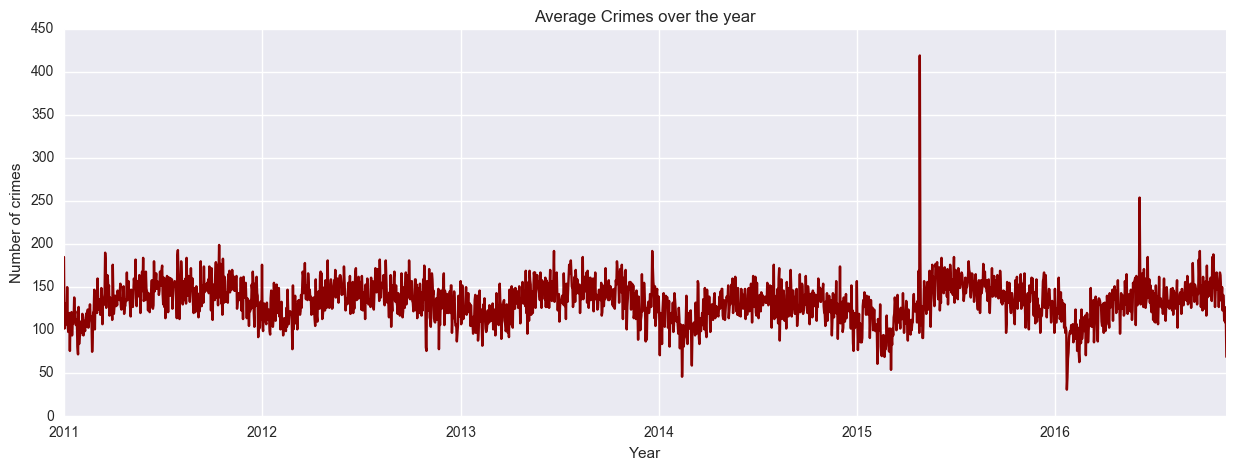

In [60]:
# Grouping the data by Year,Month and Day
crimes_day = crime_data.groupby(['Year','Month','Day'])['Day'].count()
# Putting the count to Frame
Count = crimes_day.to_frame(name='count').reset_index()
# Figure 
plt.figure(figsize=(15, 5))
plt.plot_date(crime_data.CrimeDate.unique(), Count['count'], '-',color ='darkred')
plt.ylabel('Number of crimes')
plt.xlabel('Year')
plt.title('Average Crimes over the year')

  <b>Analysis</b>
1. We see that the crimes are more in the middle of the year in the summer months as compared to the winter months as people tend to stay indoors in cold weather
2. The average number of crimes over the years are nearly constant except for the rare spike in crime in 2016

Next, we will categorize the crimes by the type and plot it with a bargraph

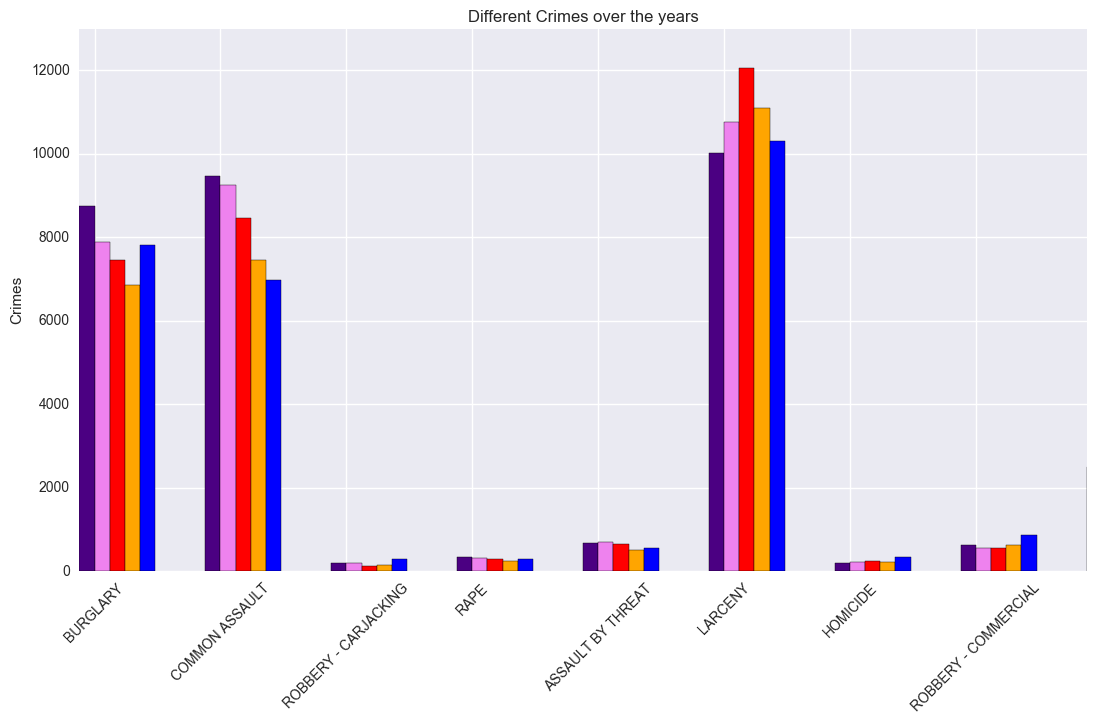

In [61]:
# Setting the custom colors
color = ['indigo','violet','red','orange','blue','black']
# Initialize c , to change the colour for each year
c = 0
# RC parameters can be set for a variety of customizing attributes
rcParams['figure.figsize'] = 13, 7
# Subplots is needed as we are plotting different years onto the same figure
fig, ax = plt.subplots()
# Loop between the years
for i in range(2011, 2016):
    crimes = np.array( crime_data.Description[crime_data.Year == i].value_counts(sort= False))
    N = crimes.shape[0]
    ind = np.arange(N)*2.5 
    width = 0.3
    p1 = plt.bar( ind + width*c*1, crimes, width, color= color[c])
    plt.ylabel('Crimes')
    plt.title('Different Crimes over the years')
    plt.xticks(ind+width, crime_data.Description[crime_data.Year == i].value_counts(sort= False).index, rotation = 45)
    plt.axis([0, 20, 0.0, 13000])
    c += 1

plt.show()

<b>Analysis</b><br>
We can see that the most common type of crime is Larceny followed by Assault and Robbery also it is observed that the assault rate is gradually decreasing over the years.

Since Assault is one of the major crimes, we now determine the choice of weapons for these crimes

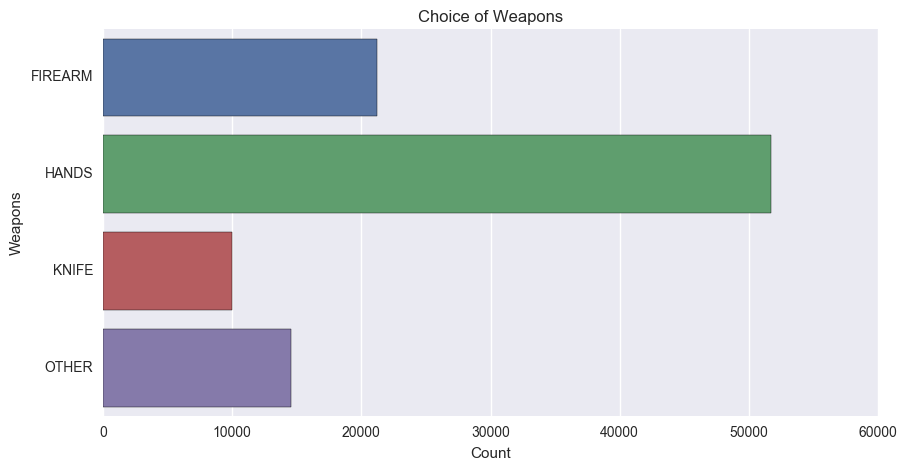

In [62]:
# Determining the Weapon Count
weapon_count = crime_data['Weapon'].value_counts().sort_index()
weapon_plot = pd.DataFrame({'Weapon': weapon_count.index, 'count': weapon_count.values})
plt.figure(figsize = (10, 5))
# Using Seaborn Barplot for 
sns.barplot(x = 'count', y = 'Weapon', data = weapon_plot)
plt.title('Choice of Weapons')
plt.xlabel('Count')
plt.ylabel('Weapons')

<b>Analysis</b><br>
We see that the Hand based Assaults are the most common choice of weapon, followed by Guns and knives

Now we will Plot the crime incidents in the area of Baltimore and create a heatmap to see where the crimes are actually happening.I used the Basemap function of mpl_toolkit for this, also Basemap Functions over different Projections
In this Case I am using Gall projection, referred http://matplotlib.org/basemap/users/gall.html for understanding the parameters
CMAP afmhot style is used which is suitable for heatmaps

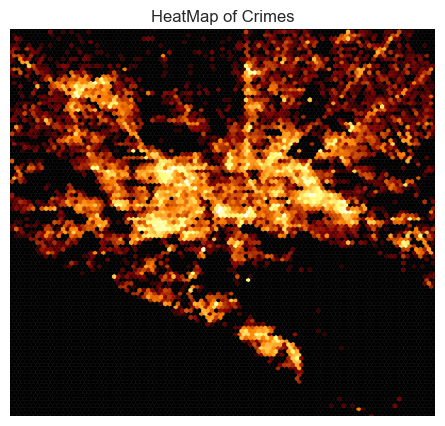

In [63]:
fig = plt.figure(figsize=(7,5))
m = Basemap(projection='gall', llcrnrlat=min(locs_lat), urcrnrlat=max(locs_lat),
            llcrnrlon=min(locs_lon), urcrnrlon=max(locs_lon), lat_ts=min(locs_lat), resolution='c')
x, y = m(pd.Series(locs_lon).values, pd.Series(locs_lat).values)
m.hexbin(x, y, gridsize=100, bins='log', cmap=cm.afmhot);
plt.title('HeatMap of Crimes')

<b>Analysis</b><br> We see that most crimes occcur in the heart of the city and the frequency of crimes decreases as we move away from the city

Now to see where the arrests are happening related to this crime, we gain make use of Basemap function, but this time instead of 
gall projection we will use the Miller's projection to visualize

http://server.arcgisonline.com/ArcGIS/rest/services/NatGeo_World_Map/MapServer/export?bbox=-76.7111193749,39.2004059842,-76.5298623566,39.3719864846&bboxSR=4269&imageSR=4269&size=3000,2839&dpi=96&format=png32&f=image


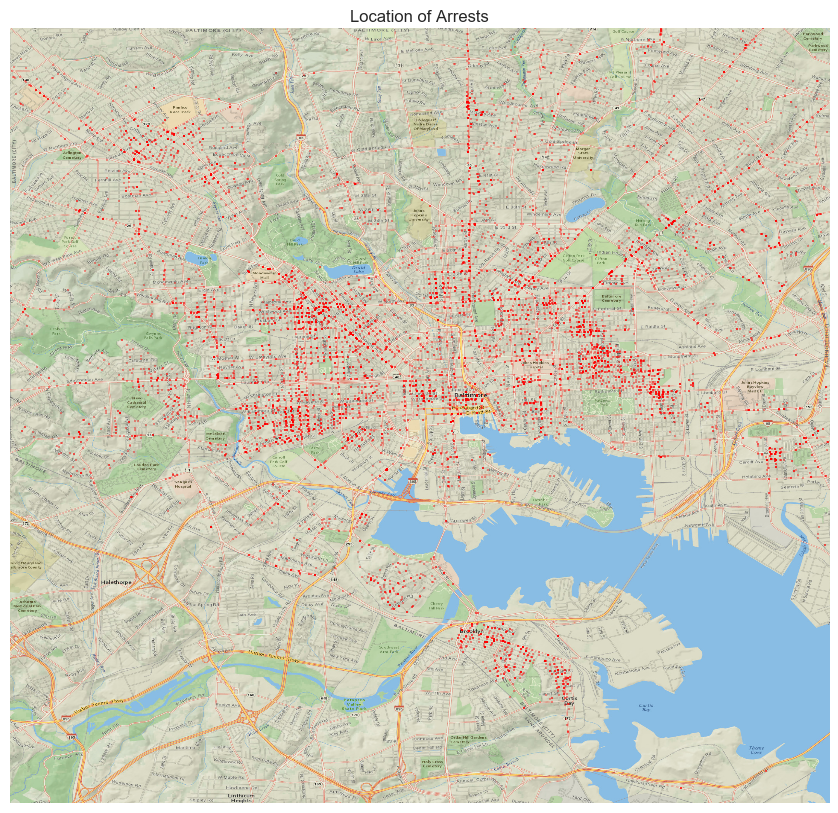

In [64]:
m = Basemap(projection='mill', llcrnrlat=arrests_data.lat.min(), urcrnrlat=arrests_data.lat.max(), 
            llcrnrlon=arrests_data.lon.min(), urcrnrlon=arrests_data.lon.max(), resolution='c', epsg=4269)
x, y = m(tuple(arrests_data.lon[(arrests_data.lon.isnull()==False) & (arrests_data.Year == 2016)]), \
         tuple(arrests_data.lat[(arrests_data.lat.isnull() == False) & (arrests_data.Year == 2016)]))

plt.figure(figsize=(20,10))
# Added the feature "NatGeo_World_Map" to add the features
# Positives : Adds the Landscape 
# Negatives: Need to click on the generated link below to make the landscape load
#          : Slow to Load 
m.arcgisimage(service="NatGeo_World_Map", xpixels=3000, verbose=True)
m.plot(x,y,'ro',markersize=1, alpha=1,color='red')
plt.title('Location of Arrests')

<b>Analysis</b><br>
Observing the Arrest locations, it can be deduced that the arrests mostly happen near the crime location 

Some more Cleansing was needed to remove the erroneous data before grouping the crime data to dervie more insights

In [65]:
crime_data = crime_data[(crime_data.District != 'Central')]
crime_data = crime_data[(crime_data.District != 'Gay Street')]
crime_data = crime_data[(crime_data.District != 'SOUTHESTERN')]
crime_data = crime_data[(crime_data.District != 'NORTHESTERN'

Finally a Heatmap is created to visualize how the crimes and arrests are distributed over the various districts of Baltimore

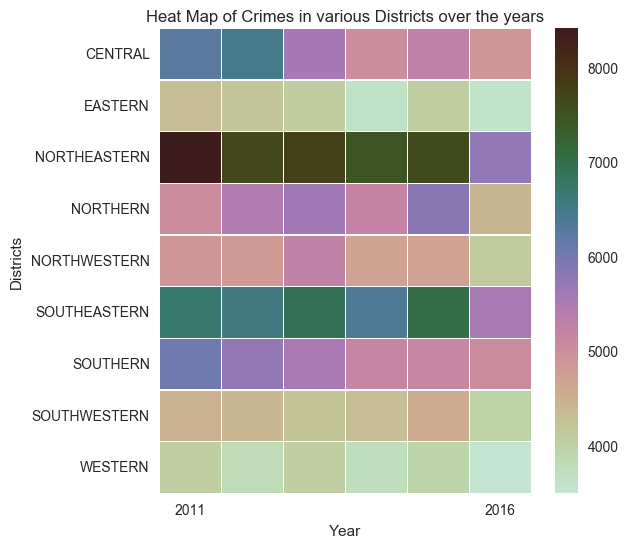

In [67]:
# Grouping the data based on District and Year and doing an index reset
crime_dist = crime_data.groupby(['District', 'Year']).count().reset_index()
# Creating pivot table for the grouped data and set the index,columns,values and the aggregate function
crime_pivot = crime_dist.pivot_table(index = 'District', columns = 'Year', values = 'IncidentLocation', aggfunc = np.mean)
# Set the figure size
plt.figure(figsize = (6, 6))
# Create the cmap rules of seaborn parameter cubehelix_palette, start and rot can be used to adjust the intensity of colors and variation
cmap = sns.cubehelix_palette(start = 0, rot = 2, as_cmap = True)
# Create the Heatmap by setting the pivot table, labels, rules and the width 
sns.heatmap(crime_pivot, xticklabels = 5, cmap = cmap, linewidths = 0.1)
# Set X label
plt.xlabel('Year')
# Set Y Label
plt.ylabel('Districts')
# Set the Title
plt.title('Heat Map of Crimes in various Districts over the years')

It is seen that the Northeastern region is the most ill-famed district in terms of crime, whereas Western District seems to be the safest
Also it is seen that the crimes of all the districts have decline over the years

Arrests

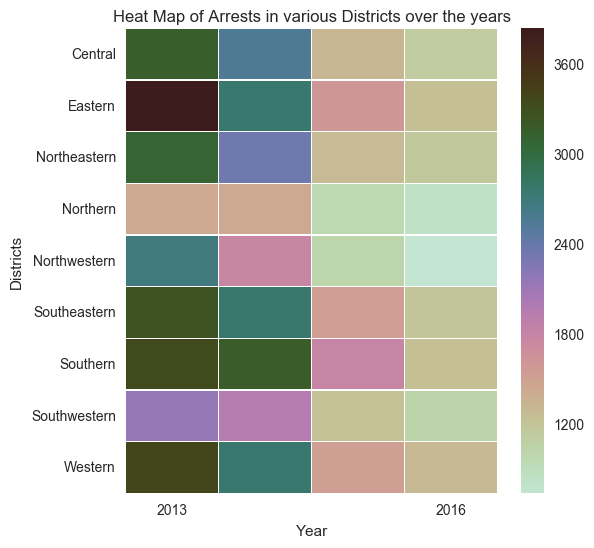

In [68]:
# Grouping the data based on District and Year and doing an index reset
arrest_dist = arrests_data.groupby(['District', 'Year']).count().reset_index()
# Creating pivot table for the grouped data and set the index,columns,values and the aggregate function
arrest_pivot = arrest_dist.pivot_table(index = 'District', columns = 'Year', values = 'IncidentLocation', aggfunc = np.mean)
# Set the figure size
plt.figure(figsize = (6, 6))
# Create the cmap rules of seaborn parameter cubehelix_palette, start and rot can be used to adjust the intensity of colors and variation
cmap = sns.cubehelix_palette(start = 0, rot = 2, as_cmap = True)
# Create the Heatmap by setting the pivot table, labels, rules and the width 
sns.heatmap(arrest_pivot, xticklabels = 3, cmap = cmap, linewidths = 0.2)
# Set X label
plt.xlabel('Year')
# Set Y Label
plt.ylabel('Districts')
# Set the Title
plt.title('Heat Map of Arrests in various Districts over the years')

Interstingy the arrests have declined for all districts over the years.
Comparing the heatmaps of Crimes and Arrests, it is seen that the arrests have declined more rapidly compared to Crimes
this suggests that the fugitives have become smarter in evading the police

<b>Conclusions</b><br>The final Conclusion which can be derived from the study of these datasets is that the Crimes have reduced over the year
and Baltimore's Law enforcement has ensured that the crimes are kept at bay.